In [153]:
# Trying to write a loop that goes through each image file and compares image i to image i+1

from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio

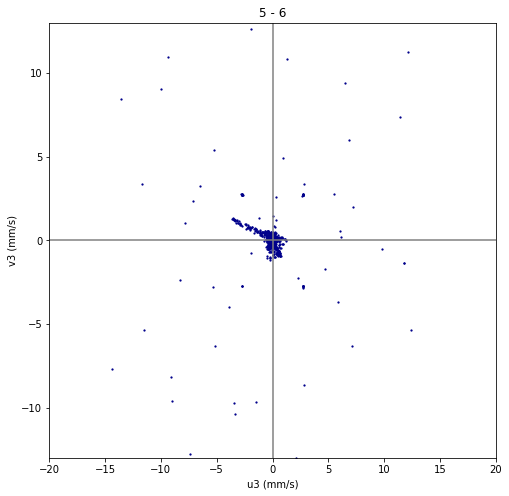

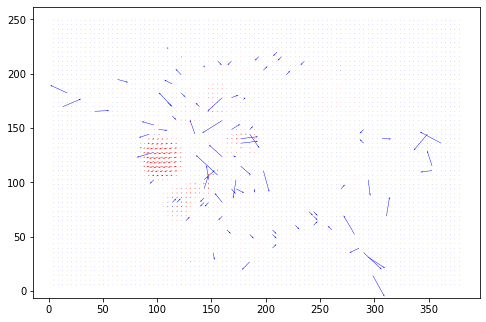

0.153486417687827


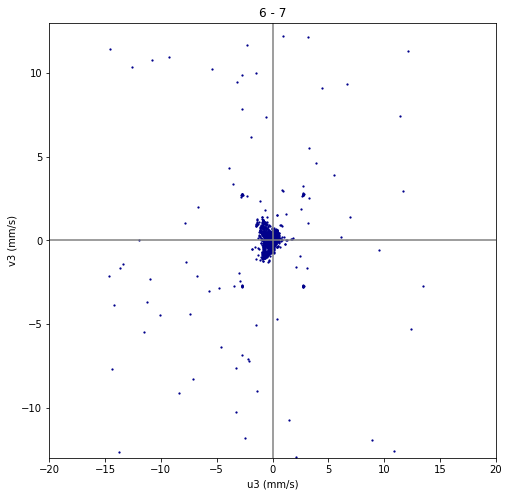

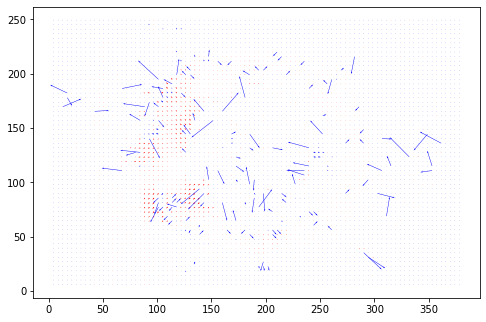

0.24359013958524242


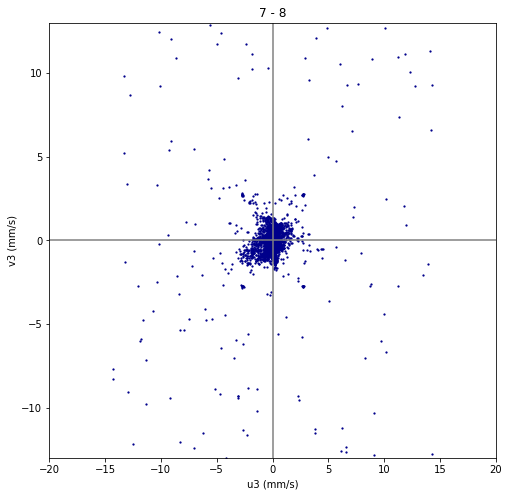

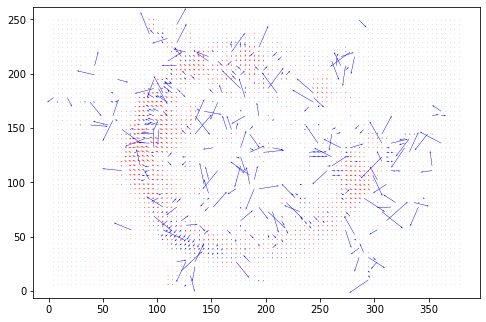

0.6076441020414904


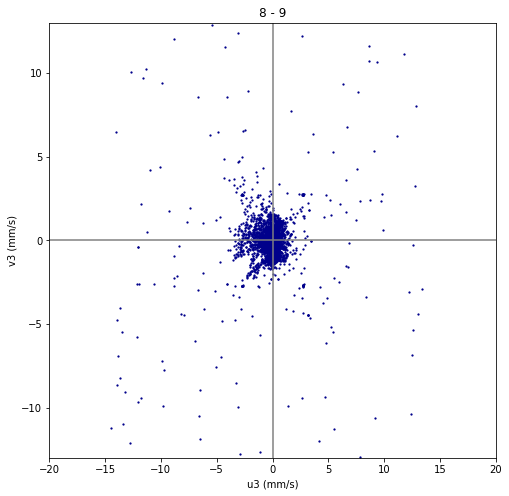

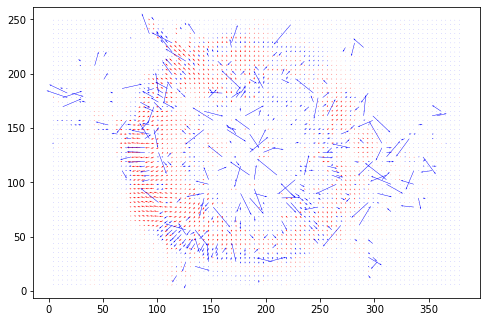

0.6574182961937816


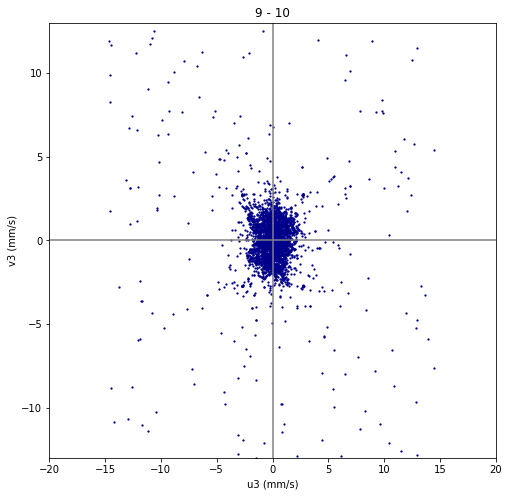

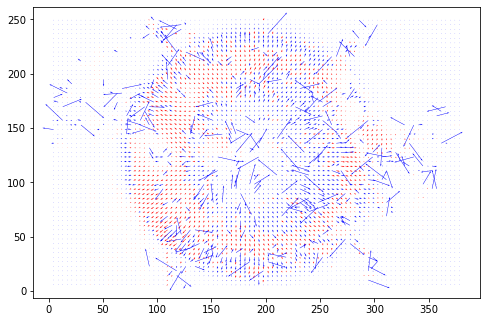

0.9573583829913824


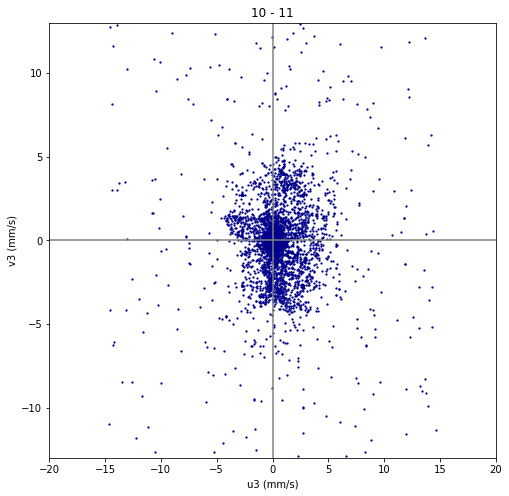

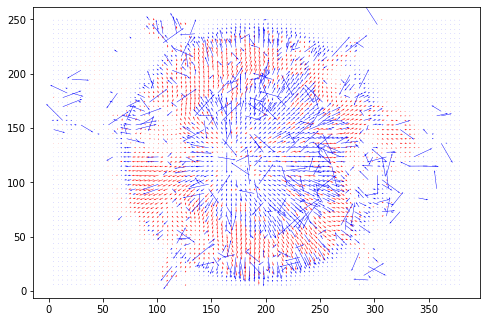

1.4027305318055976


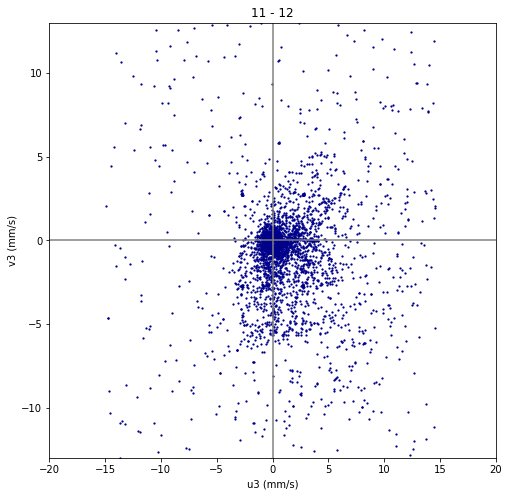

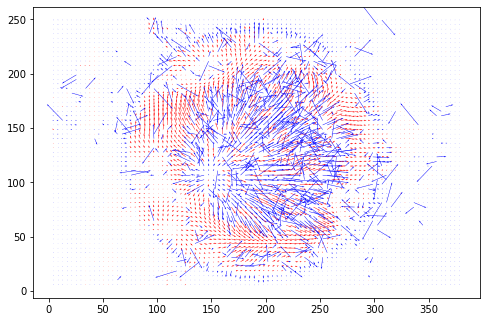

1.7008145139617572


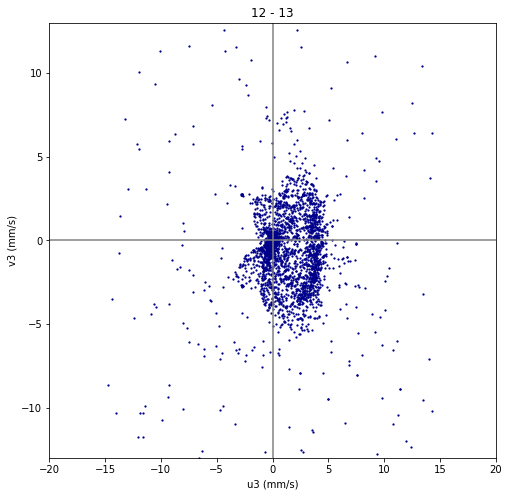

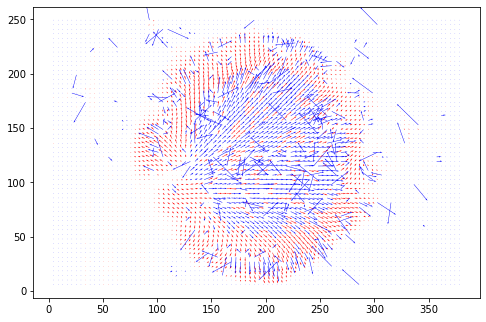

1.1306020517382058


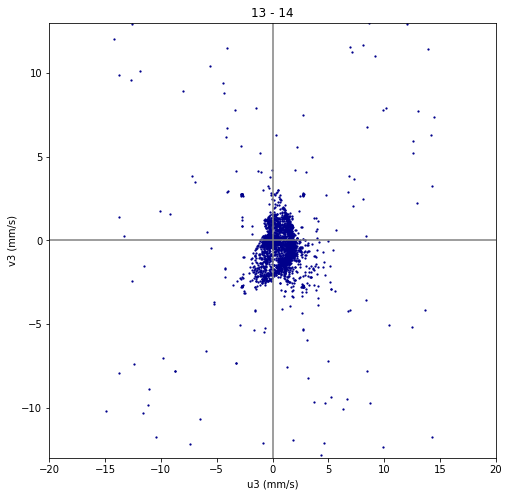

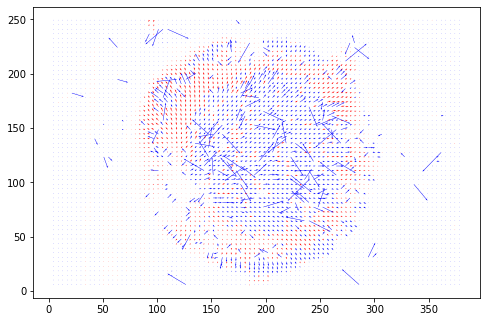

0.6976444042153442


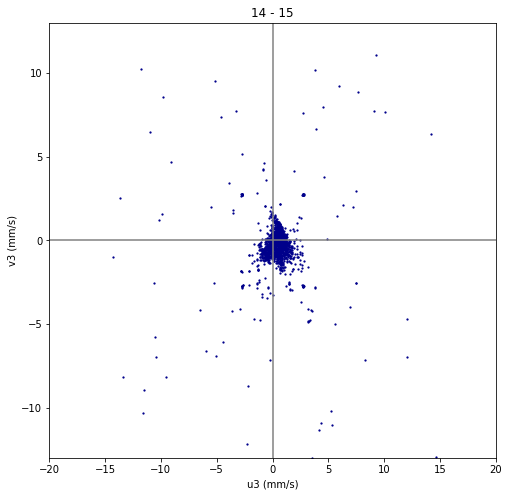

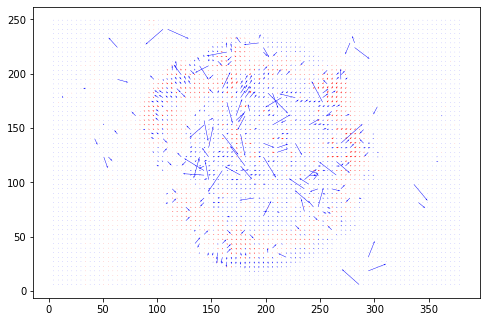

0.45089264117807504


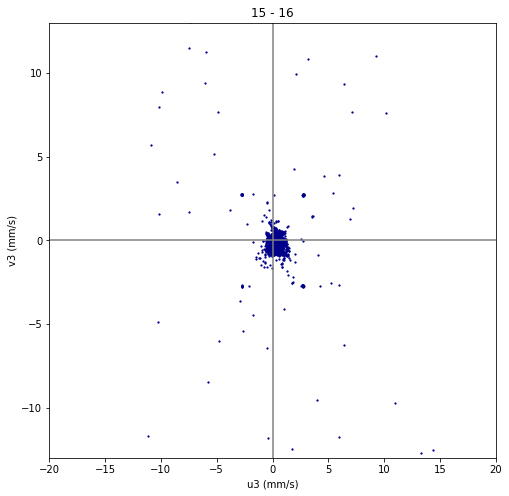

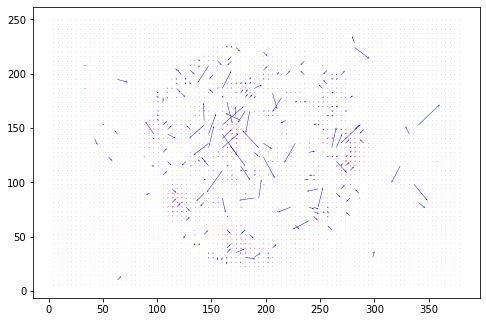

0.31525888397528024


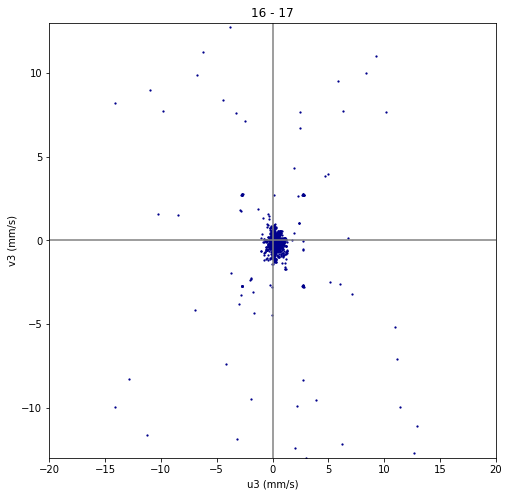

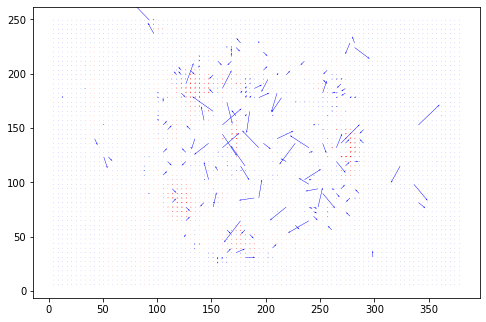

0.2780910800146403


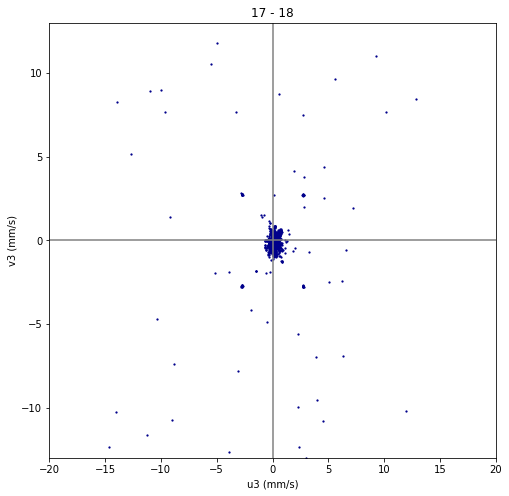

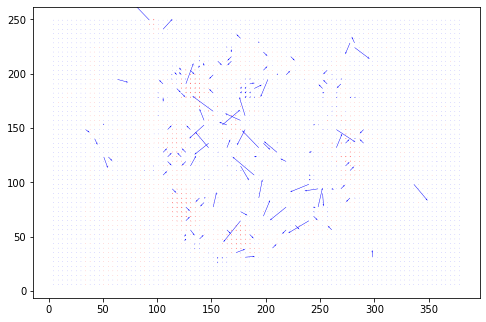

0.22969471688845153


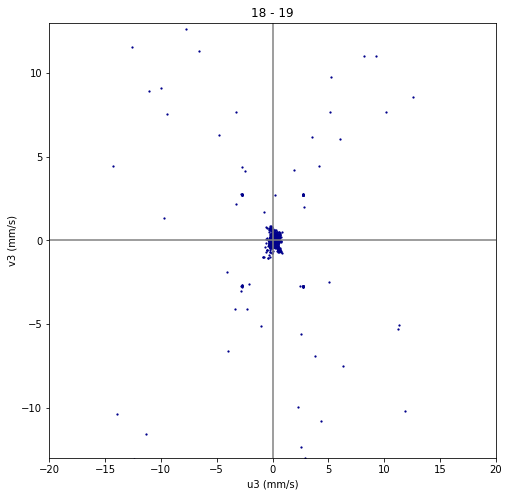

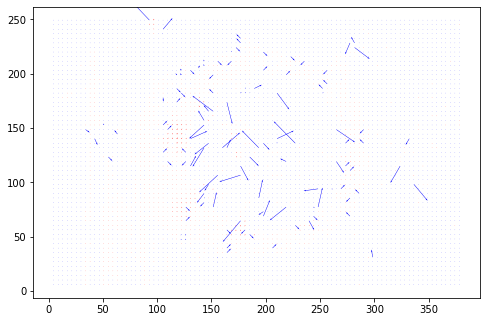

0.19172086544984585


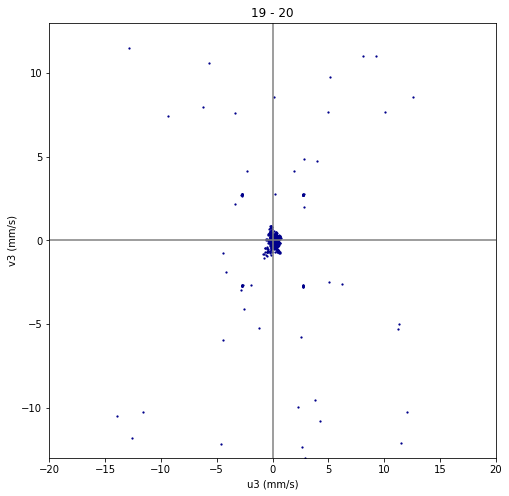

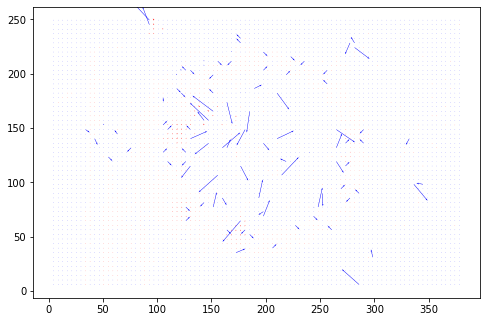

0.16667988487182417


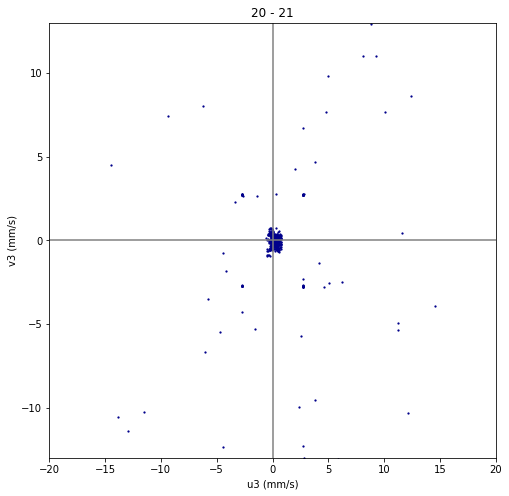

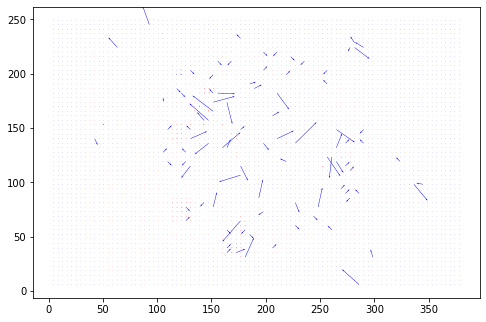

0.1654828421016461


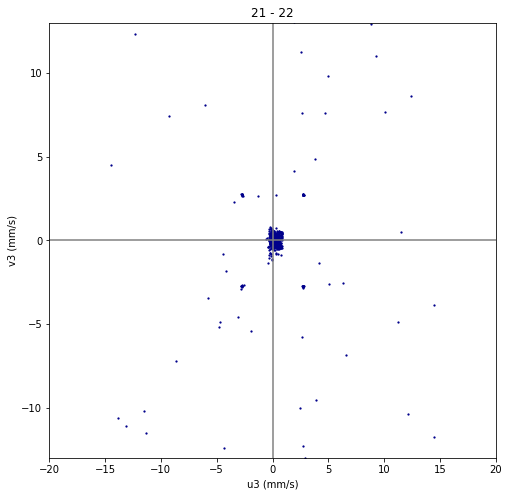

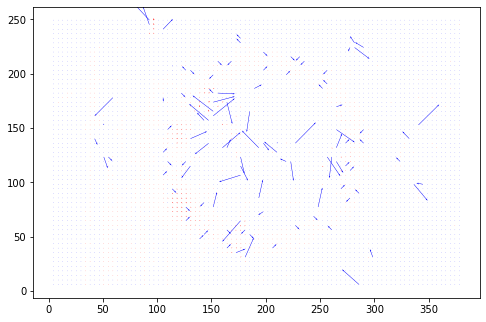

0.18617650974650188


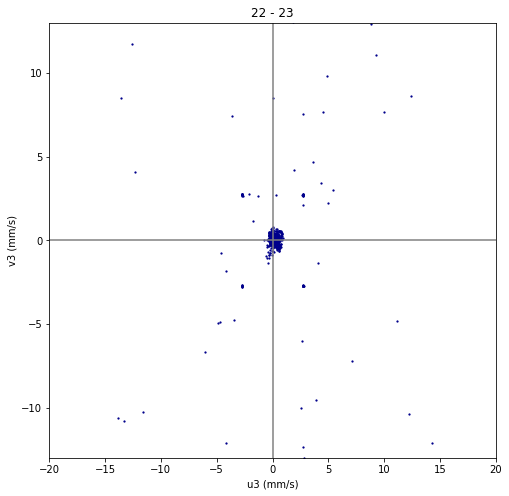

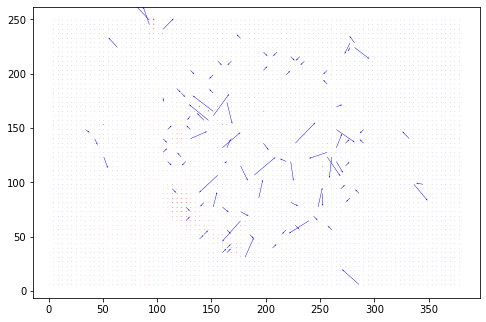

0.16764501939191953


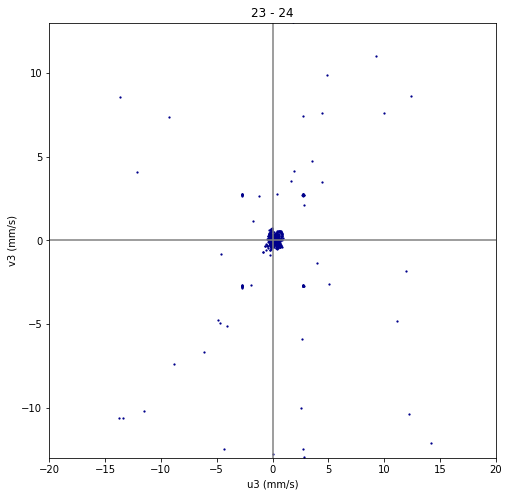

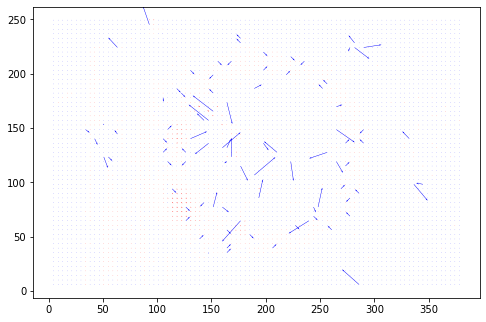

0.14104843164432643


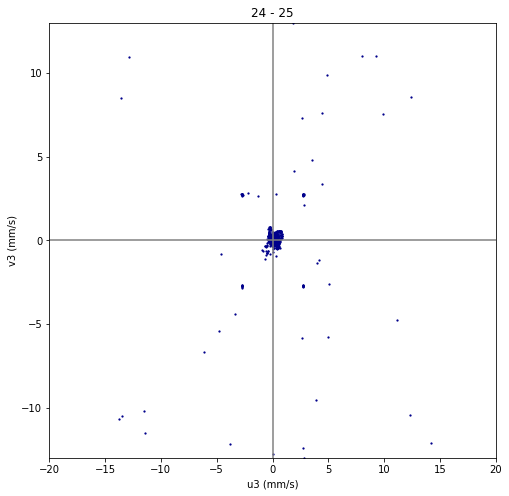

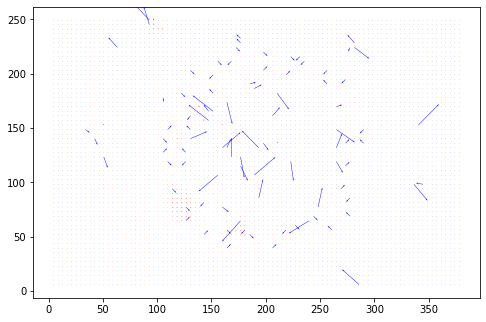

0.14980948696712015


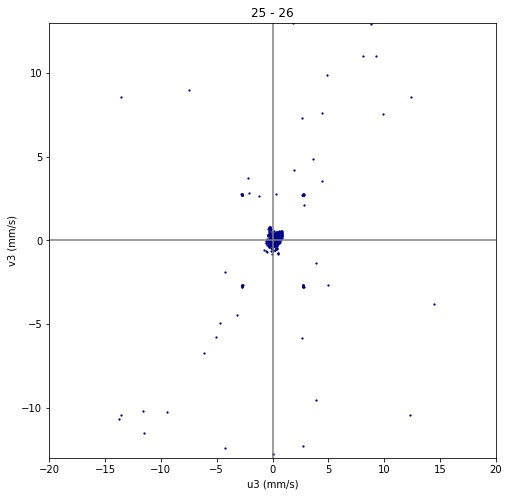

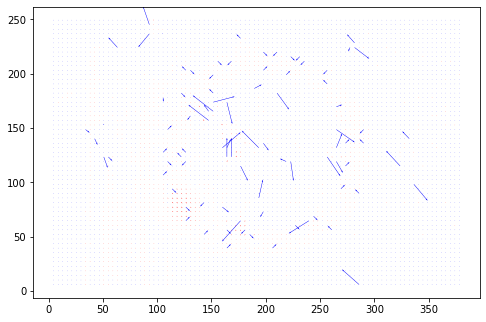

0.14008092868033628


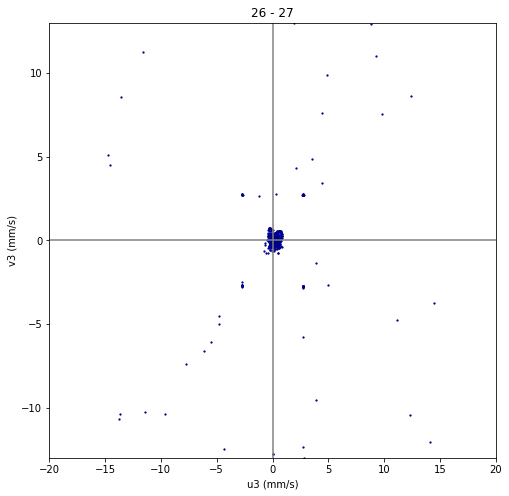

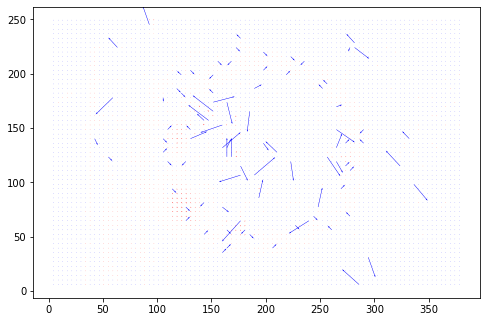

0.15207409085151857


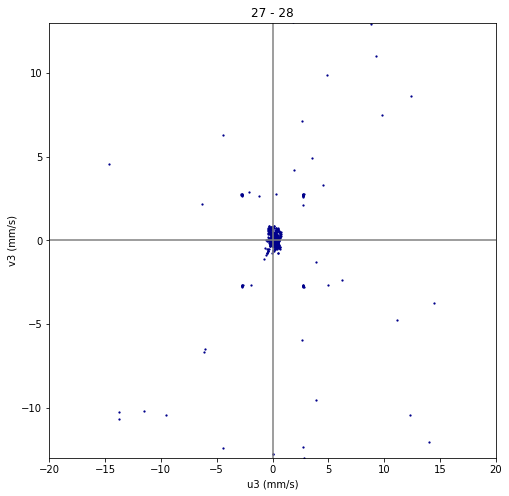

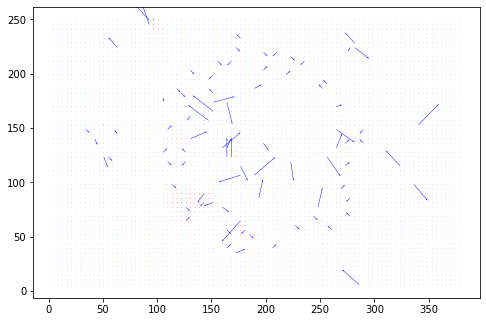

0.14320133951082684


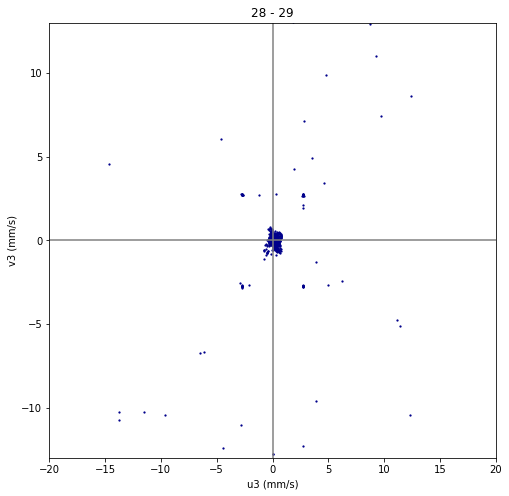

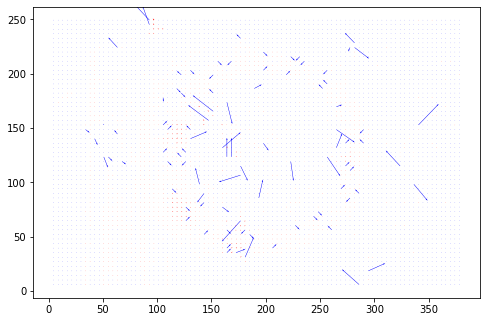

0.1438972092591727


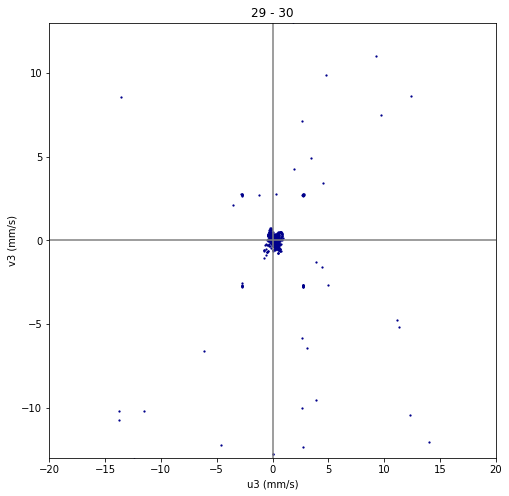

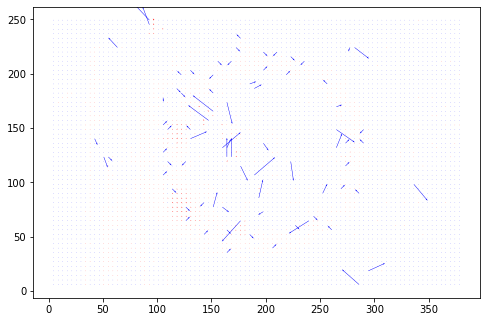

0.12726065699306416


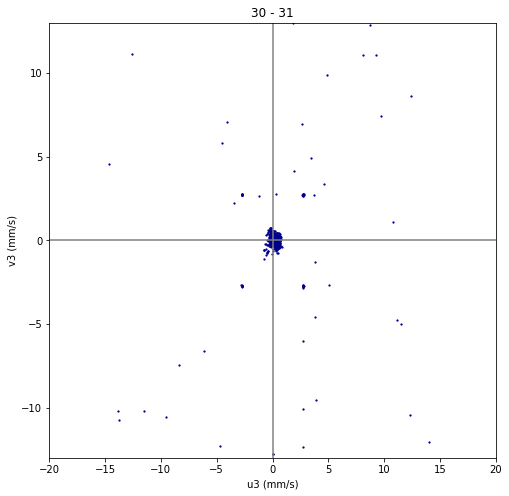

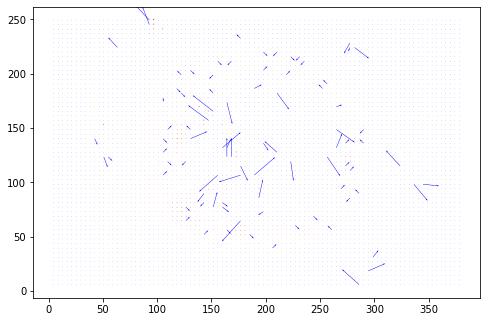

0.14720143646088552


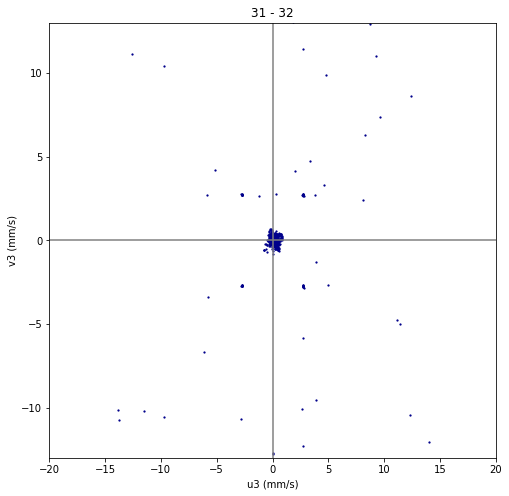

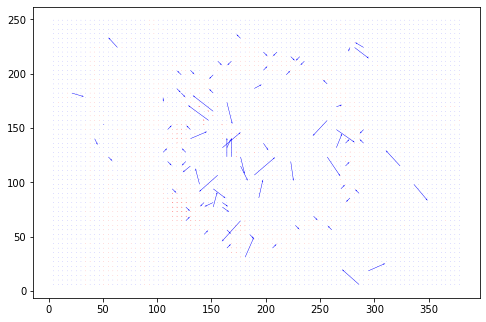

0.140888948826468


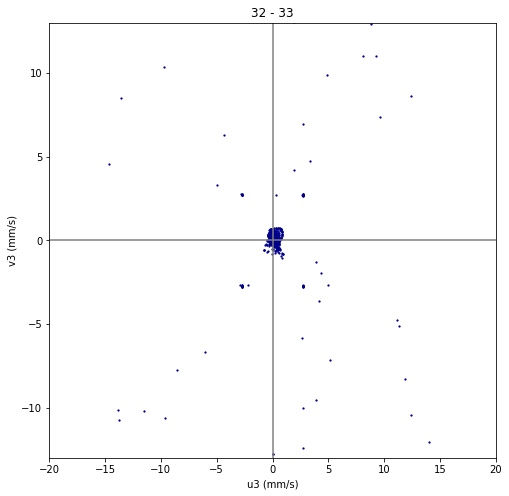

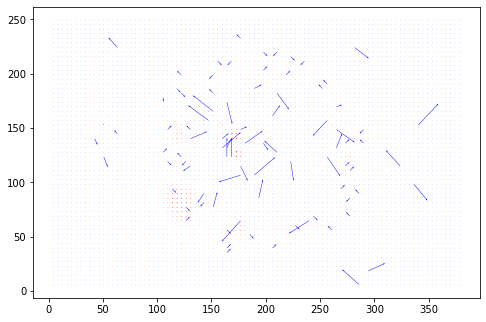

0.145909042105208


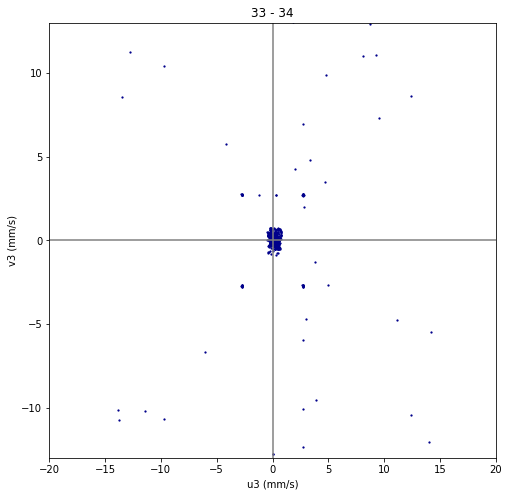

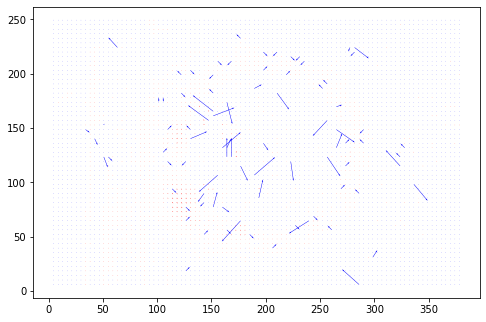

0.1373080185909303


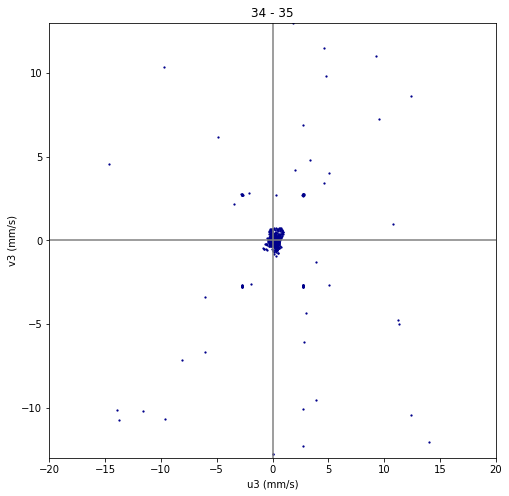

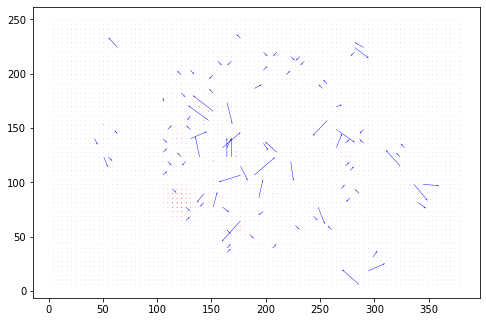

0.1434743446980664


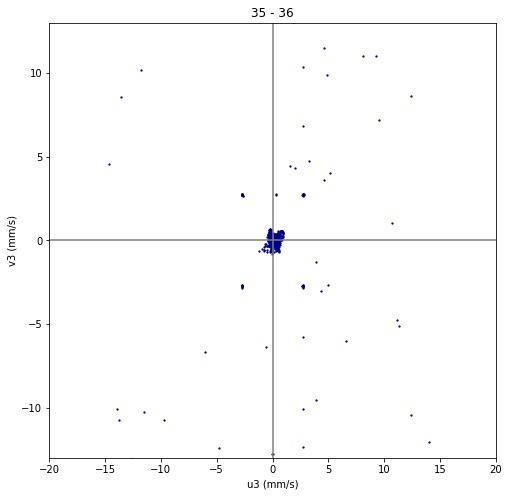

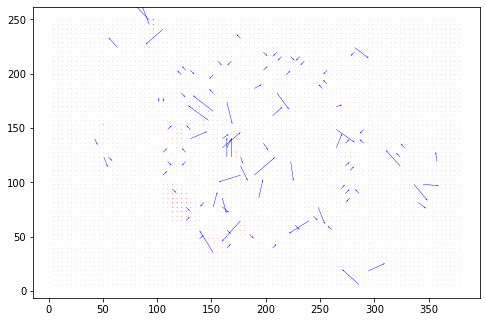

0.1572811303049491


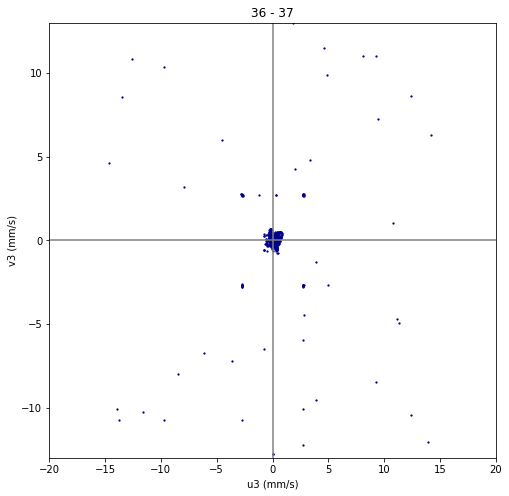

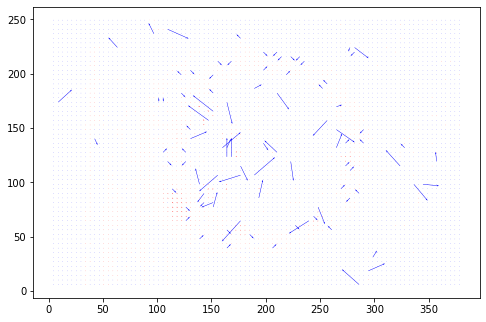

0.1523826728679198


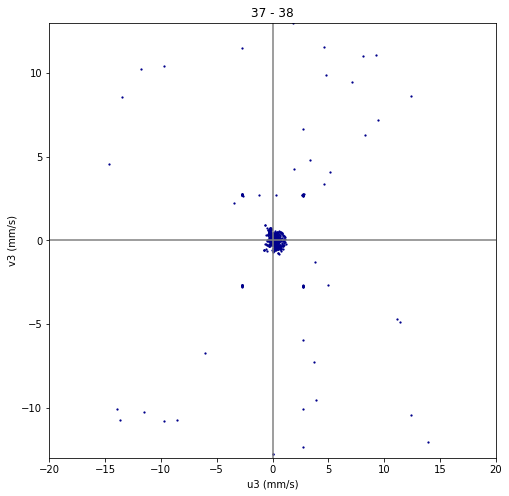

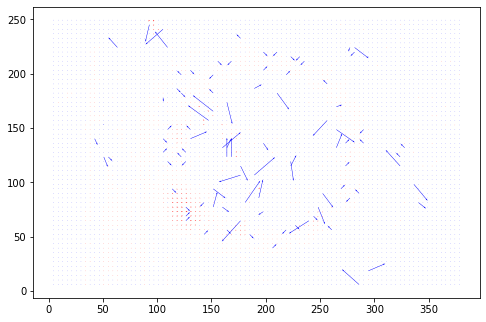

0.1545108862135751
done


In [155]:
#OpenPIV analysis section of code

path_to_file = './Default/'
image_beg  = 'img_channel000_position000_time00000000'
#img_channel000_position000_time000000008_z000.tif
image_begs = 'img_channel000_position000_time0000000'
image_end = '_z000.tif'
number_frames= 38 # number of images - 1 (because we analyze index vs index + 1)
index=5  #starts at 5
magnitude_averages = []
index_array = []

while (index<number_frames):
    if (index <= 8):
        frame_a  = tools.imread(path_to_file + image_beg+ str(index) + image_end )
        frame_b  = tools.imread(path_to_file + image_beg + str(index+1) + image_end )
    elif (index == 9):
        frame_a  = tools.imread(path_to_file + image_beg + str(index) + image_end )
        frame_b  = tools.imread(path_to_file + image_begs + str(index+1) + image_end )
    else:
        frame_a  = tools.imread(path_to_file + image_begs + str(index) + image_end )
        frame_b  = tools.imread(path_to_file + image_begs + str(index+1) + image_end )

    #show two frames using matplotlib
    #fig,ax = plt.subplots(1,2,figsize=(12,10))
    #ax[0].imshow(frame_a,cmap=plt.cm.gray)
    #ax[1].imshow(frame_b,cmap=plt.cm.gray)
    
    
    winsize = 90 # pixels, interrogation window size in frame A
    searchsize = 110  # pixels, search in image B
    overlap = 50 # the number of pixels by which two adjacent windows overlap
    dt = 0.255 # sec, time interval between pulses

    """ 1. extended_search_area_piv
    Standard PIV cross-correlation algorithm, with an option for
    extended area search that increased dynamic range. The search region
    in the second frame is larger than the interrogation window size in the
    first frame.
    Returns two dimensional array containing the u/v velocity component, in pixels/seconds.
    """
    u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')


    """2. get_coordinates
    Compute the x, y coordinates of the centers of the interrogation windows.
    the origin (0,0) is like in the image, top left corner
    positive x is an increasing column index from left to right
    positive y is increasing row index, from top to bottom
    """
    x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )
    
    
    """3. sig2noise_val
    Eliminate spurious vectors from cross-correlation signal to noise ratio.
    Replace spurious vectors with zero if signal to noise ratio is below a specified threshold.
    Returns 2d np.ndarray
    a two dimensional array containing the v velocity component,
    where spurious vectors have been replaced by NaN.
    a boolean 2d array, true elements correspond to outliers
    """
    u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05 )
   
    # if you need more detailed look, first create a histogram of sig2noise
    #plt.hist(sig2noise.flatten())
    # to see where is a reasonable limit
    
    
    """
    Filter out outliers that are very different from the neighbours
    For each element in the arrays of the ``u`` and ``v`` components,
    replace it by a weighted average
    of the neighbouring elements which are not invalid themselves.
    """
    u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)
    
    """
    converts to mm and mm/s 
    returns x/scaling_factor,
    with Form2 rig, have 10mm/700px = 14.29um/1pixel
    """
    x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 14.29) # x microns/pixel

    """
    scatter plot of u3 and v3
    saves to folder ./scatterplots
    """
    plt.figure(figsize=(8, 8)) # set fig size and make it square[] 
    plt.scatter(u3, v3, 1.5, color = 'darkblue') # plot data
    plt.xlabel("u3 (mm/s)")  # x axis label
    plt.ylabel("v3 (mm/s)")  # y axis label
    plt.title(str(index)+' - '+str(index+1)) # title 
    plt.axvline(0,0, color='grey') # sets grid color
    plt.axhline(0,0, color='grey')
    plt.axis([-20, 20, -13, 13]) # set axis limit
    plt.savefig('./scatterplots/frame'+str(index)+'_'+str(index+1)+'.png', dpi=300)

    
    # 0,0 shall be bottom left, positive rotation rate is counterclockwise
    x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)
    
    #save in the simple ASCII table format
    tools.save(x, y, u3, v3, mask, 'vectorfield_filteredimages.txt' )
    
    fig, ax = plt.subplots(figsize=(8,8))

    tools.display_vector_field('vectorfield_filteredimages.txt', 
                           on_img=False, # overlay on the image #NOT WORKING WITH LOOP. WHY?
                           image_name = frame_a,
                           window_size = 32, 
                           scaling_factor=1, 
                           scale=300, # scale defines here the arrow length. Bigger number = smaller arrow
                           width=0.001, # width is the thickness of the arrow
                           ax=ax, # think it puts axis on vector plot
                           );
    fig.suptitle(str(index)+' - '+str(index+1))  # gives title 
    fig.savefig('./vectorplots/frame'+str(index)+'_'+str(index+1)+'.png', dpi=300)  #saves to ./vectorplots
   
    
    
    
    # get avg of magnitudes for each txt file
    # get filename from command line arguments

    path = './vectorfield_filteredimages.txt'

    # arrays for results
    magnitudes = []
    xyuv = []
    mag_sum = 0
    total = 0
    # open the file. Each file compares two frames 
    with open(path) as fp:
        # iterate over each line in the file
        for line in fp:
            total = total +1
            # ignore header line
            if line.startswith('#'):
                continue
            # extract fields (convert to floats)
            x, y, u, v, mask = map(float, line.split())
            # convert mask to integer
            mask = int(mask)
            # ignore masked-out fields
            if mask != 0:
                continue
            # store numbers
            xyuv.append((x, y, u, v))
            # compute magnitude and store in array
            m = np.linalg.norm([u, v])
            magnitudes.append(m)
            #add each magnitude tp mag_sum
            mag_sum = mag_sum + m
          
    #find avg magnitude        
    mag_avg = mag_sum/total 
    #store avg magnitude in array 
    magnitude_averages.append(mag_avg)
    index_array.append(index)
    index = index +1 # increase index each loop such that frame1+frame2, frame2+frame3, etc for comparison
   


    #print(mag_sum)
    print(mag_avg)
    
    #print(magnitudes)
    # X, Y, U, V = zip(*xyuv)
    # plt.quiver(X, Y, U, V)
    # plt.show()
    # plt.hist(magnitudes)
    # plt.show()

    
#done loop stuff    
print('done')

   

[0.3606727449663306, 0.5261917525463341, 1.3076985577846834, 1.5242296978672942, 2.063813193337274, 3.2272325094279988, 3.9633223575371916, 2.7358032872055644, 1.524909956227624, 0.9349970413174993, 0.6452069462629572, 0.567212908255388, 0.4670441383682155, 0.3748058183598904, 0.3311055421302719, 0.32725670973710286, 0.36966868084879323, 0.3352762774899591, 0.2928928582685905, 0.3066837383231945, 0.28656173758607095, 0.3134507952032602, 0.29790345166143506, 0.30155588706874725, 0.2757048888975825, 0.3004027340967618, 0.2864579815281969, 0.3028547732023786, 0.28680721019664424, 0.2958613319568277, 0.3241695183032413, 0.30639070642856886, 0.318661938991221]


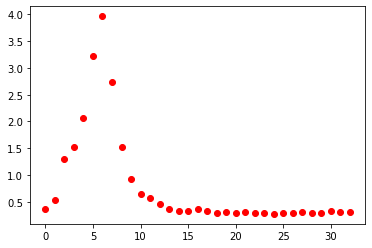

In [146]:
#messing around with the magnitude plots to check it out before plotting it below
print(magnitude_averages)
new_array = []
a = 0
for x in magnitude_averages:
    new_array.append(a) #just an x axis for plotting 
    a+=1
    
plt.scatter(new_array, magnitude_averages, color ="red")

In [147]:
import pandas as pd

# reading csv file, calling it df
df = pd.read_csv("../Squish5mmps.csv")
#print(df)

#take interesting columns and convert to arrays to be plotted
t_host_s = df['t_host_s'].to_numpy()
time_s = ((df['t_us'].to_numpy()))*(1e-6) #convert from us to ms
Fl = df['Fl'].to_numpy()
Mpos = df['Mpos'].to_numpy()


#shift t_s array so that it starts at 0
t_s = [] # new time array
shift = time_s[0]
for time in time_s:
    t_s.append(time-shift)


In [148]:
#loop through Mpos until z<=10, then return t_us that corresponds to height
image_start_index = np.argmax(Mpos<9) #did 9 bc it was being weird. in case the closest timestamp is just above. 
print(image_start_index) 
print(t_s[image_start_index])


#now loop through and make a timestap index based on time between images. In future, get actual timestamps
image_times = []
i = 0 
for x in magnitude_averages:
    image_times.append(i*255*0.001) #255 ms interval from metadata.txt 
    i+=1

#Now push array elements so that first element = t_us[image_start_index] (ie time when position hit 10mm)
#the 10 mm light trigger is set in script, so always double check number 
image_times = image_times + t_s[image_start_index]
print(image_times)


46
4.471336999999949
[ 4.471337  4.726337  4.981337  5.236337  5.491337  5.746337  6.001337
  6.256337  6.511337  6.766337  7.021337  7.276337  7.531337  7.786337
  8.041337  8.296337  8.551337  8.806337  9.061337  9.316337  9.571337
  9.826337 10.081337 10.336337 10.591337 10.846337 11.101337 11.356337
 11.611337 11.866337 12.121337 12.376337 12.631337]


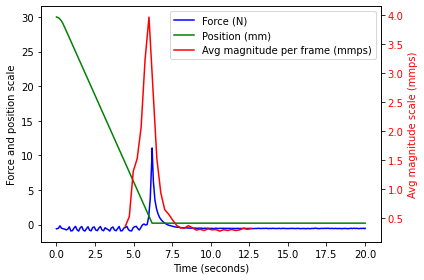

In [149]:
#time to plot all this together
#goint to plot with two diff y axes, but on same x axis 

# create figure and axis objects with subplots()
fig, ax1 = plt.subplots()


ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Force and position scale')

force = ax1.plot(t_s, Fl, label='Force (N)', color='blue' )
position = ax1.plot(t_s, Mpos, label='Position (mm)', color='g')


# twin object for two different y-axis on the sample plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# make a plot with different y-axis using second axis object
ax2.set_ylabel('Avg magnitude scale (mmps)', color='red')  # we already handled the x-label with ax1
magnitude = ax2.plot(image_times, magnitude_averages, label='Avg magnitude per frame (mmps)', color='red')
ax2.tick_params(axis='y', labelcolor='red') # set flow axis to blue and give title
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Solution for having two legends
leg = force + position + magnitude
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)

plt.savefig('5mmps_unfilteredimagesPlot.png', dpi=300)

plt.show()




# plot Force and Mpos
#plt.plot(t_s, Fl, label='Force (N)')
######plt.plot(t_s, Mpos, label='Position (mm)')
#plt.xlabel("Time (seconds)")


#add magnitude_averages array to plot
#plt.plot(image_times, magnitude_averages, label='Avg magnitudes per frame (mmps)')
#plt.legend()
#plt.axvline(t_s[image_start_index],0, color='grey')
#fig.axis([image_times[0]-1, image_times[-1]+1, 0, 20]) # set axis limit. just before piv start to just after.
#plt.savefig('5mmps_unfilteredimagesPlot.png')

